In [1]:
#Import packages
import time
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import pickle
import random
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import segmentation_models as sm

import utils.parameters
from utils.model import s3ar_unet
from utils.save_load import save_h, load_h
from utils.eval import cost_compute, jacard_coef
from utils.test_loader import test_loader, read_image, read_mask, mask_parse

from utils.layers import (squeeze_excite_block, 
                          spatial_squeeze_excite_block, 
                          channel_spatial_squeeze_excite,
                          stem_block,
                          resnet_block,
                          attention_block,
                          single_conv_block,
                          fsm)

from utils.preprocess import (atoi, 
                              natural_keys, 
                              data_loader, 
                              read_image, 
                              read_mask, 
                              tf_parse, 
                              tf_dataset, 
                              read_and_rgb)

from glob import glob
from PIL import Image
from math import ceil
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import MeanIoU

from skimage import io
from skimage.io import imsave
from skimage.transform import resize
from tensorflow.keras.utils import normalize
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
print("Packages successfully loaded")

tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2024-12-18 17:01:51.811837: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/targets/x86_64-linux/lib:
2024-12-18 17:01:51.811851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `tf.keras` framework.
Packages successfully loaded


# PARAMETER TWEAKING

In [2]:
#Parameter configurations
#Class
num_classes = 1

model_name = 'SeARUNet'
experiment_number = '1'

model_name = model_name + '-' + experiment_number

save_name =  model_name

print('Model to be trained is:', model_name)
print('Model is to be saved as:', save_name)

Model to be trained is: SeARUNet-1
Model is to be saved as: SeARUNet-1


In [3]:
#Set hyper-parameters
batch_size = 16
epochs = 25
optimizer = RMSprop
learning_rate = 1e-3
smooth = 1.0

print('Batch size is set to:', batch_size)
print('Epochs is set to:', epochs)
print('Optimizer is set to:', optimizer.__name__)
print('Learning Rate is set to:', learning_rate)
print('Smoothing is set to:', smooth)

Batch size is set to: 16
Epochs is set to: 25
Optimizer is set to: RMSprop
Learning Rate is set to: 0.001
Smoothing is set to: 1.0


# DATASET PREPARATION

In [4]:
import re

PATH = "/home/voicelab/Desktop/segmentation_glottis/datasets/BAGLS_2_1_ROI/training"

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

images = sorted(glob(os.path.join(PATH, "*[!_seg].png")))  # Imágenes que no tienen '_seg' en el nombre
masks = sorted(glob(os.path.join(PATH, "*_seg.png")))      # Máscaras que tienen '_seg' en el nombre

images.sort(key=natural_keys)
masks.sort(key=natural_keys)

print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")


Number of images: 55750
Number of masks: 55750


# Preprocess

In [5]:
#split with labels
(train_x, train_y), (val_x, val_y)= data_loader(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(val_x))

Training data:  52963
Validation data:  2787


# Check Train Data

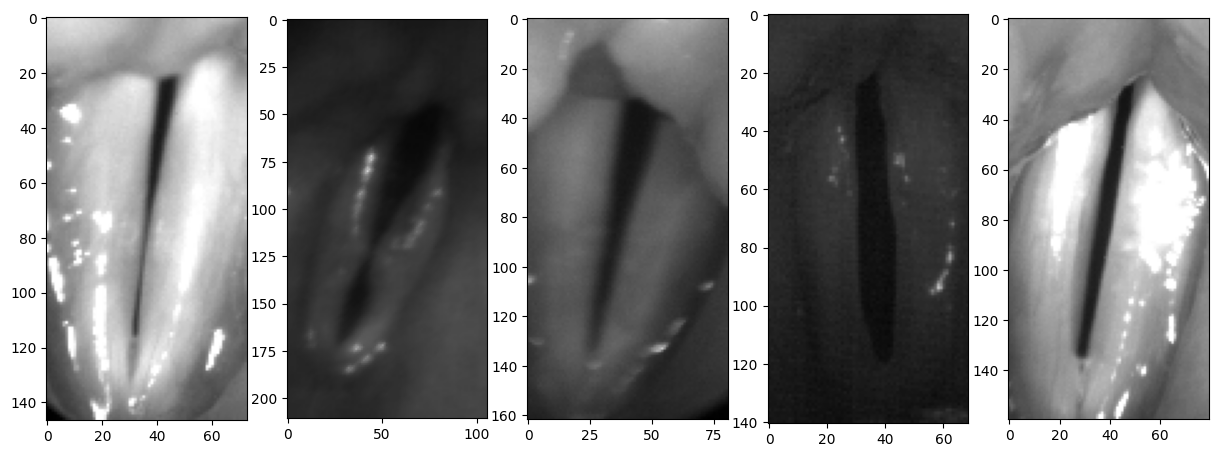

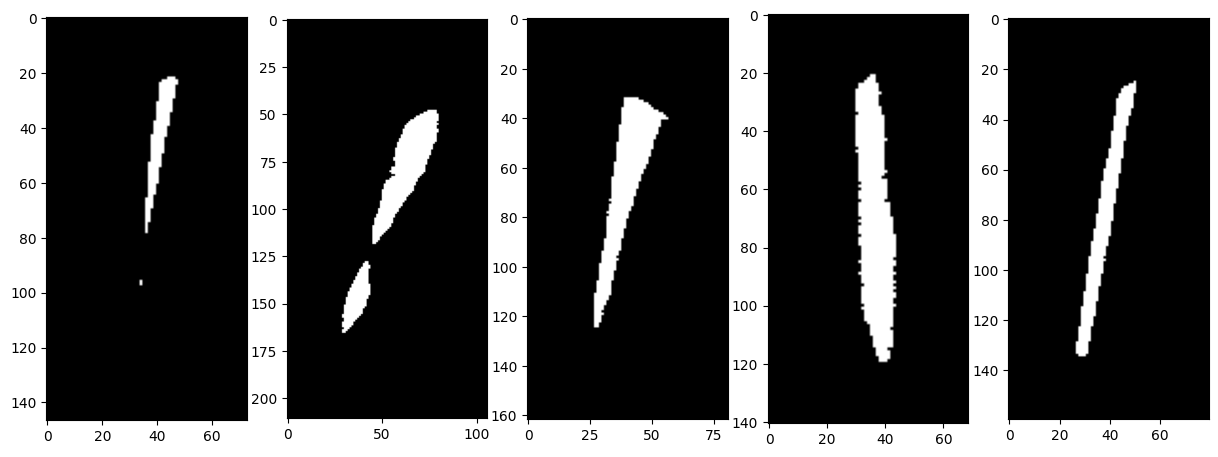

In [6]:
#Train data viewer
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(train_x[4]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(train_y[4]))
imgplot.set_clim(0.0, 1.4)

# Check Validation Data

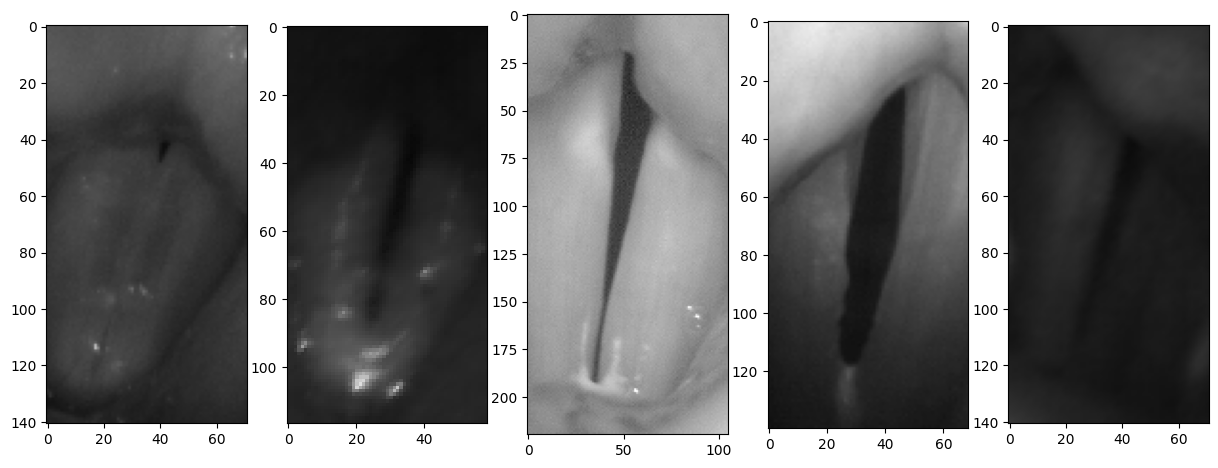

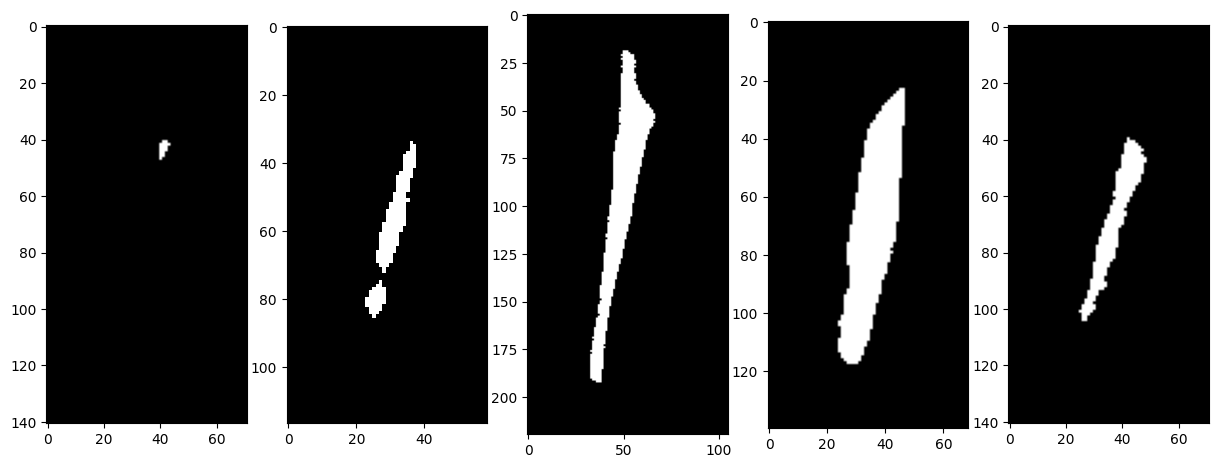

In [7]:
#Val data viewer
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(val_x[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(val_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(val_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(val_x[3]))
imgplot.set_clim(0.0, 2.1)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(val_x[4]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(val_y[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(val_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(val_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(val_y[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(val_y[4]))
imgplot.set_clim(0.0, 1.4)

# Produce Datasets

In [8]:
#Create datasets
train_dataset = tf_dataset(train_x, train_y, batch=8)
val_dataset = tf_dataset(val_x, val_y, batch=8)

2024-12-18 17:01:54.546447: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-18 17:01:54.546926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-12-18 17:01:54.560887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-18 17:01:54.562302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.58GHz coreCount: 80 deviceMemorySize: 15.59GiB deviceMemoryBandwidth: 685.51GiB/s
2024-12-18 17:01:54.562354: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No s

# BUILD AND COMPILE MODEL

In [9]:
#Initialize the model
print('-'*30)
print('Creating model...')
print('-'*30)
model = s3ar_unet()
model.summary()

------------------------------
Creating model...
------------------------------
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32), dtype=tf.float32, name=None), name='re_lu_8/Relu6:0', description="created by layer 're_lu_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 32), dtype=tf.float32, name=None), name='re_lu_15/Relu6:0', description="created by layer 're_lu_15'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 16), dtype=tf.float32, name=None), name='re_lu_22/Relu6:0', description="created by layer 're_lu_22'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 8), dtype=tf.float32, name=None), name='re_lu_29/Relu6:0', description="created by layer 're_lu_29'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 8), dtype=tf.float32, name=None), name='re_lu_33/Relu6:0', description="created by layer 're_lu_33'")
Model: "S3AR_UNet"
__________________________________________________________________________________________________
Layer (type)               

                                                                  'separable_conv2d_85[0][0]']    
                                                                                                  
 depthwise_conv2d_4 (DepthwiseC  (None, 8, 8, 8)     520         ['separable_conv2d_86[0][0]']    
 onv2D)                                                                                           
                                                                                                  
 add_38 (Add)                   (None, 16, 16, 8)    0           ['multiply_31[0][0]',            
                                                                  'multiply_32[0][0]']            
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 16, 16, 8)   0           ['depthwise_conv2d_4[0][0]']     
                                                                                                  
 separable

                                                                 0]']                             
                                                                                                  
 dense_32 (Dense)               (None, 1, 1, 4)      128         ['reshape_36[0][0]']             
                                                                                                  
 dense_33 (Dense)               (None, 1, 1, 32)     128         ['dense_32[0][0]']               
                                                                                                  
 separable_conv2d_93 (Separable  (None, 32, 32, 1)   64          ['add_41[0][0]']                 
 Conv2D)                                                                                          
                                                                                                  
 multiply_36 (Multiply)         (None, 32, 32, 32)   0           ['add_41[0][0]',                 
          

In [12]:
#Calculate the cost
cost_compute(model)

2024-12-18 17:04:47.258789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-18 17:04:47.260446: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-12-18 17:04:47.260516: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2024-12-18 17:04:47.260638: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-18 17:04:47.260732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-18 17:04:47.261912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUP


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

# COMPILE MODEL

In [14]:
#Compile the model
from segmentation_models.losses import BinaryFocalLoss

model.compile(
    optimizer=optimizer(learning_rate=learning_rate),
    loss=BinaryFocalLoss(),
    metrics=[
        'accuracy',
        sm.metrics.Precision(threshold=0.5, smooth=smooth),
        sm.metrics.Recall(threshold=0.5, smooth=smooth),
        sm.metrics.FScore(threshold=0.5, smooth=smooth, name='F1/DSC'),
        sm.metrics.IOUScore(threshold=0.5, smooth=smooth, name='IOU/JaccardIndex'),
        sm.metrics.IOUScore(threshold=0.5, smooth=smooth, per_image=True, name='MeanIOU'),
    ]
)


print('Selected optimizer:', optimizer.__name__)
print('Learning rate:', learning_rate)

print('-'*26)
print(' '*4 +'--Model compiled--')
print('-'*26)

Selected optimizer: RMSprop
Learning rate: 0.001
--------------------------
    --Model compiled--
--------------------------


# PREPARE MODEL DIRECTORY TO SAVE

In [15]:
#Prepare directory for saving the model.
model_dir = 'model/'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print('Model directory', model_dir, 'successfully created')
else:
    print('Model directory already exist, no new directory made.')

print()
print('-'*49)
print('Model directory is available for saving the model!')
print('-'*49)

Model directory already exist, no new directory made.

-------------------------------------------------
Model directory is available for saving the model!
-------------------------------------------------


# SET GENERATORS FOR TRAINING

In [16]:
train_steps = (len(train_x) // batch_size)
val_steps = (len(val_x) // batch_size)

# BEGIN TRAINING

In [17]:
#Train the model with the preprocessed data
print('-'*30)
print('Training model', save_name, '.'*5)
print('-'*30)

#Set timer
start_time = time.time()

history = model.fit(train_dataset,   
                  epochs=epochs,
                  steps_per_epoch=train_steps, 
                  validation_steps=val_steps,
                  validation_data=val_dataset,
                  verbose=1)

elapsed_time = time.time() - start_time
train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print()
print()
print(train_time, 'train_time')
print()
print(elapsed_time, 'Seconds')
print()
print()
print("MODEL SERIALIZING WAIT FOR A MOMENT...")
print()
print()
print('-'*130)
print(' '*53, model_name, 'successfully trained...')
print('-'*130)

------------------------------
Training model SeARUNet-1 .....
------------------------------
Epoch 1/25


2024-12-18 17:07:02.380583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


3310/3310 [==============================] - 700s 209ms/step - loss: 0.0054 - accuracy: 0.9763 - precision: 0.9361 - recall: 0.7172 - F1/DSC: 0.7928 - IOU/JaccardIndex: 0.6820 - MeanIOU: 0.6260 - val_loss: 0.0023 - val_accuracy: 0.9806 - val_precision: 0.9744 - val_recall: 0.7874 - val_F1/DSC: 0.8691 - val_IOU/JaccardIndex: 0.7712 - val_MeanIOU: 0.7049
Epoch 2/25
3310/3310 [==============================] - 711s 215ms/step - loss: 0.0022 - accuracy: 0.9819 - precision: 0.9599 - recall: 0.8338 - F1/DSC: 0.8907 - IOU/JaccardIndex: 0.8048 - MeanIOU: 0.7400 - val_loss: 0.0020 - val_accuracy: 0.9830 - val_precision: 0.9552 - val_recall: 0.8742 - val_F1/DSC: 0.9122 - val_IOU/JaccardIndex: 0.8395 - val_MeanIOU: 0.7775
Epoch 3/25
3310/3310 [==============================] - 702s 212ms/step - loss: 0.0020 - accuracy: 0.9826 - precision: 0.9631 - recall: 0.8442 - F1/DSC: 0.8984 - IOU/JaccardIndex: 0.8171 - MeanIOU: 0.7552 - val_loss: 0.0020 - val_accuracy: 0.9806 - val_precision: 0.9876 - val_re

# Evaluate the model

In [18]:
val_dataset = tf_dataset(val_x, val_y, batch=8)

val_steps = (len(val_x)//batch_size)
if len(val_x) % batch_size != 0:
    val_steps += 1

In [19]:
#Evaluate the model
print('Evaluating', save_name)
print()
print()
model.evaluate(val_dataset, steps=val_steps, return_dict=True)

Evaluating SeARUNet-1


175/175 [==============================] - 11s 62ms/step - loss: 0.0014 - accuracy: 0.9835 - precision: 0.9806 - recall: 0.8611 - F1/DSC: 0.9165 - IOU/JaccardIndex: 0.8467 - MeanIOU: 0.7917


{'loss': 0.0014336614403873682,
 'accuracy': 0.9835335612297058,
 'precision': 0.9805842638015747,
 'recall': 0.8611230254173279,
 'F1/DSC': 0.9165317416191101,
 'IOU/JaccardIndex': 0.8467345237731934,
 'MeanIOU': 0.7917292714118958}

# PLOT RESULTS

In [ ]:
#Plot accuracy results
plt.plot(history.history['F1/DSC'])
plt.plot(history.history['val_F1/DSC'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train dice coeff', 'Test dice coeff'], loc='best')
plt.show()

#Plot loss results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Save Model and History

In [25]:
#Sets the directory to save the model
save_folder = 'model3/' + save_name + '/'
saved_model = save_folder + save_name + '.h5'
print('File is to be saved in ', save_folder, 'folder ' + 'as', save_name)

File is to be saved in  model3/SeARUNet-1/ folder as SeARUNet-1


In [26]:
#Saves the entire structure and weights
model.save(saved_model)
print('successfully saved in as', saved_model)

successfully saved in as model3/SeARUNet-1/SeARUNet-1.h5


In [27]:
#Save the History
import os
save_h(save_folder, history.history)

NameError: name 'os' is not defined

In [ ]:
#Load the History
history = load_h(model_name)

print(model_name, "history loaded!")

In [ ]:
# Loads the entire structure and weights
model = load_model(saved_model, compile=False)

In [ ]:
model_path = '/home/voicelab/Desktop/segmentation_glottis/models/UNets/S3AR-UNet/s3ar_unet/model/SeARUNet-1/SeARUNet-1.h5'
model = load_model(model_path, compile=False)

# EVALUATION

In [39]:
TEST_PATH = "/home/voicelab/Desktop/segmentation_glottis/datasets/BAGLS_2_1_ROI/test"
#TEST_PATH = "/home/voicelab/Desktop/segmentation_glottis/datasets/BAGLS/test/test"
(test_x, test_y) = test_loader(TEST_PATH)

print("Test images: ", len(test_x))
print("Test mask: ", len(test_y))

Test images:  3500
Test mask:  3500


In [40]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [41]:
test_step = (len(test_x) // batch_size)

In [42]:
!pip install tensorflow-addons


In [43]:
#Compile the model
import tensorflow_addons as tfa

model.compile(
    optimizer=optimizer(learning_rate=learning_rate), 
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=[
        'accuracy', 
        sm.metrics.Precision(threshold=0.5, smooth=smooth),
        sm.metrics.Recall(threshold=0.5, smooth=smooth),
        sm.metrics.FScore(threshold=0.5, smooth=smooth, name='F1/DSC'),
        sm.metrics.IOUScore(threshold=0.5, smooth=smooth, name='IOU/JaccardIndex'),
        sm.metrics.IOUScore(threshold=0.5, smooth=smooth, per_image=True, name='MeanIOU')
    ]
)


print('Selected optimizer:', optimizer.__name__)
print('Learning rate:', learning_rate)

print('-'*26)
print(' '*4 +'--Model compiled--')
print('-'*26)

ImportError: cannot import name 'tf_utils' from 'keras.utils' (/home/voicelab/miniconda3/envs/s3ar-unet/lib/python3.8/site-packages/keras/utils/__init__.py)

In [44]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

test_steps = (len(test_x)//batch_size)
if len(test_x) % batch_size != 0:
    test_steps += 1

In [45]:
model.evaluate(test_dataset, steps=test_steps, return_dict=True)

219/219 [==============================] - 23s 105ms/step - loss: 0.0026 - accuracy: 0.9833 - precision: 0.9523 - recall: 0.7973 - F1/DSC: 0.8668 - IOU/JaccardIndex: 0.7667 - MeanIOU: 0.6810


{'loss': 0.0025772361550480127,
 'accuracy': 0.983260452747345,
 'precision': 0.952280580997467,
 'recall': 0.7972674369812012,
 'F1/DSC': 0.8668354749679565,
 'IOU/JaccardIndex': 0.7666705846786499,
 'MeanIOU': 0.6810493469238281}